# WDB - Web scraping

- Rami Tarabishi

In [2]:
import pandas as pd
import numpy as np
import time
import re

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementNotInteractableException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

In [3]:
# route_df = pd.DataFrame(columns=['outgoing_code', 'incoming_code', 'frequency'])
route_df = pd.read_csv('../Data/flight_routes.csv')

In [4]:
# price_df = pd.DataFrame(columns=['outgoing', 'incoming', 'stops', 'duration', 'price', 'airline'])
price_df = pd.read_csv('../Data/flight_prices.csv')

In [5]:
# price_df_long = pd.DataFrame(columns=['outgoing', 'incoming', 'stops', 'duration', 'price', 'airline'])
price_df_long = pd.read_csv('../Data/flight_prices_long.csv')

In [99]:
chrome_options = Options()

# chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-notifications")
chrome_options.add_argument("--disable-images")

In [100]:
# Launch the browser
driver = webdriver.Chrome(options=chrome_options)
driver.implicitly_wait(2)
wait = WebDriverWait(driver, timeout=5)

actions = ActionChains(driver)

## Getting air routes:

For testing/WDB purposes, Im going to limit myself to routes out of zurich cause I believe there will be enough data. (~200 non-stop routes from flightsfrom * multiple different flights to get there with different airlines etc * the date range for prices)

FLightsfrom gives all non-stop direct flights from a given airport, this obviously doesnt cover all possible routes from zurich. So maybe scraping the top 100 airports of each continent would be a good idea to add more routes.

P.S: There technically is a small popup ad that shows up on the website, but you need to be on a page for about 10 seconds before it shows up so it isnt a problem, and anyway we dont need to interact with the website much to get all the data loaded.

In [7]:
# # Scrape top N airports and their connections
# driver.get('https://www.flightsfrom.com/top-100-airports')

# # Wait for table to be loaded
# wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'hometoplist')))

# # Run through the airports
# try:
#     # Get the rows of the table
#     rows = driver.find_elements(By.CLASS_NAME, 'hometoplist-item')

#     # Since im leaving the main page after I get all the rows, the elements become stale so I save all the urls before hand
#     urls = []
#     for row in rows:
#         urls.append(row.get_attribute('href'))

#     # Go to each airport
#     for i in range(len(urls)):
#     # for row in rows:
#         url = urls[i]
#         # Set current outgoing airport
#         outgoing_code = url[-3:]

#         # Go to the airport page
#         driver.get(url)

#         # Wait for the table to be loaded
#         wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'uk-list')))

#         # Since some rows are hidden scroll and click to the show all button
#         try:
#             show_all_button = driver.find_element(By.CLASS_NAME, 'ff-show-all')
#             banner = driver.find_element(By.ID, 'header')
#             # Top banner is in the way so account for the banner height
#             driver.execute_script(f'window.scroll(0, {show_all_button.location["y"] - banner.size["height"]})')
#             show_all_button.click()
#         except:
#             pass

#         # Get the outbound routes
#         routes = driver.find_elements(By.CLASS_NAME, 'ff-li-list')

#         # Go through each route and save it to the dataframe
#         data_list = []
#         for route in routes:
#             incoming_code = route.find_element(By.CLASS_NAME, 'ff-row-name').text[:3]
#             data_list.append({'outgoing_code': outgoing_code, 'incoming_code': incoming_code})

#         data = pd.DataFrame.from_dict(data_list)
#         route_df = pd.concat([route_df, data], ignore_index=True)
#         # Wait for a bit for rate limits
#         time.sleep(2)
# except TimeoutException:
#     print('TimeoutException')

## Zurich only routes:

In [8]:
# # Restricted to just Zurich
# driver.get('https://www.flightsfrom.com/ZRH')

# # # Wait for table to be loaded
# wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'flightsfrom-list-header')))

# # Not all rows are immediately loaded so scroll to the bottom of the page and click the show all button
# try:
#     show_all_button = driver.find_element(By.CLASS_NAME, 'ff-show-all')
#     banner = driver.find_element(By.ID, 'header')
#     driver.execute_script(f'window.scroll(0, {show_all_button.location["y"] - banner.size["height"]})')
#     show_all_button.click()
# except (TimeoutException, NoSuchElementException):
#     print('Could not find show all button!')

# outgoing_code = 'ZRH'

# # Get the rows of the table
# try:
#     rows = driver.find_elements(By.CLASS_NAME, 'ff-li-list')

#     # Go through each row and save the data to the dataframe
#     data_list = []
#     for row in rows:
#         row_text = row.text.split('\n')

#         # Get the incoming airport code
#         incoming_code = row_text[0][:3]
#         frequency = row_text[-2]

#         data_list.append({'outgoing_code': outgoing_code, 'incoming_code': incoming_code, 'frequency': frequency})

#     data = pd.DataFrame.from_dict(data_list)
#     route_df = pd.concat([route_df, data], ignore_index=True)

# except TimeoutException:
#     print('TimeoutException: Could not find table rows')

In [9]:
route_df.head()

,outgoing_code,incoming_code,frequency
0,ZRH,LHR,8-13 flights per day
1,ZRH,BER,6-12 flights per day
2,ZRH,AMS,8-10 flights per day
3,ZRH,FRA,8-10 flights per day
4,ZRH,PMI,6-12 flights per day


In [10]:
# route_df.to_csv('../Data/flight_routes.csv', index=False)

## Getting flight details and prices:

Need to change the parser function to use regex so its more robust

In [97]:
def parse_flight_text(text: str, dates: tuple = (None, None)) -> dict:
    '''
    A function to parse the text of a flight element
    -----
    Input:
        text: The text of the flight element
        dates (Optional): A tuple with the dates of the flight (departure, return)
    -----
    Returns:
        A dictionary with the parsed data
    '''
    # Split the text into lines
    nonstop = False
    seperate_ticket = False

    lines = text.split('\n')
    if lines[3].split(' ')[0] == 'Separate':
        seperate_ticket = True
        if lines[7] == 'Nonstop':
            nonstop = True
        else:
            nonstop = False

    if lines[6] == 'Nonstop':
        nonstop = True

    # Get the outgoing and incoming airports
    outgoing = lines[5][:3]
    incoming = lines[5][-3:]

    # If there are stops in the flight a new line exists so we need to account for that
    if nonstop and not seperate_ticket:
        stops = 0

        # Get the duration
        duration = re.findall(r'\d+', lines[4])

        # Get the price check if unavailable first
        if lines[9].split(' ')[-1] == 'unavailable':
            price = np.nan
        else:
            price = int(''.join(re.findall(r'\d+', lines[9])))

        # Get the airline
        airline = lines[3]
    elif not nonstop and seperate_ticket:
        stops = int(lines[7].split(' ')[0])

        # Get the duration
        duration = re.findall(r'\d+', lines[4])

        # Get the price check if unavailable first
        if lines[11].split(' ')[-1] == 'unavailable':
            price = np.nan
        else:
            price = int(''.join(re.findall(r'\d+', lines[10])))

        # Get the airline
        airline = lines[4]
    else:
        stops = int(lines[6].split(' ')[0])

        # Get the duration
        duration = re.findall(r'\d+', lines[4])

        # Get the price check if unavailable first
        if lines[10].split(' ')[-1] == 'unavailable':
            price = np.nan
        else:
            price = int(''.join(re.findall(r'\d+', lines[10])))

        # Get the airline
        airline = lines[3]

    return {
        'outgoing': outgoing,
        'incoming': incoming,
        'stops': stops,
        'duration': duration,
        'price': price,
        'airline': airline,
        'departure_date': dates[0],
        'return_date': dates[1]
    }

Im just scraping the flights that are in the lists without expanding the lists, it should give me enough data points over a long period of time/many routes. Ideally I would scrape the expanded list but im adding complexity and time for quite frankly irrelevant data points to what I would want to do with the data.

In [ ]:
# Set date range to be scraped YYYY-MM-DD
static_start_date = '2024-07-01'
start_date = pd.to_datetime(static_start_date)
holiday_duration = 7
end_date = pd.to_datetime('2024-08-01')

driver.get('https://www.google.com/travel/flights')

# Google opens to a cookie page every new session, so reject the cookies as one always should
try:
    buttons = driver.find_elements(By.TAG_NAME, 'button')

    for button in buttons:
        declines = ['decline', 'Decline', 'DECLINE', 'Reject', 'reject', 'REJECT']
        if any(decline in button.text for decline in declines):
            button.click()
            break
except (TimeoutException, NoSuchElementException):
    print('Could not find decline button')

# Wait for any inputs to be loaded
wait.until(EC.presence_of_element_located((By.TAG_NAME, 'input')))

# First search - This needs to be done as the UI changes from first search to subsequent searches and there is no way to navigate/search using urls (obfuscated)
try:
    inputs = driver.find_elements(By.TAG_NAME, 'input')
except (TimeoutException, NoSuchElementException):
    print('Could not find input fields')

for input_field in inputs:
    if input_field.get_attribute('aria-label') is not None:
        match input_field.get_attribute('aria-label'):
            case 'Where from?':
                input_field.clear()
                input_field.send_keys(route_df.iloc[0]['outgoing_code'])
                # Pick the first suggestion from the dropdown
                list_elements = driver.find_elements(By.TAG_NAME, 'li')
                for li in list_elements:
                    if li.get_attribute('role') == 'option':
                        time.sleep(1)
                        actions.send_keys(Keys.RETURN).perform()
                        break
                time.sleep(1)
            case 'Where to? ':
                first_route = route_df.iloc[0]['incoming_code']
                input_field.send_keys(first_route)
                # Pick the first suggestion from the dropdown
                list_elements = driver.find_elements(By.TAG_NAME, 'li')
                for li in list_elements:
                    if li.get_attribute('role') == 'option':
                        time.sleep(1)
                        actions.send_keys(Keys.RETURN).perform()
                        break
                time.sleep(1)
            case 'Departure':
                try:
                    input_field.send_keys(start_date.strftime('%Y-%m-%d'))
                    time.sleep(1)
                    input_field.send_keys(Keys.RETURN)
                    time.sleep(1)
                except ElementNotInteractableException:
                    pass
            case 'Return':
                try:
                    return_date = start_date + pd.Timedelta(days=holiday_duration)
                    input_field.send_keys(return_date.strftime('%Y-%m-%d'))
                    time.sleep(1)
                    input_field.send_keys(Keys.RETURN)
                    time.sleep(1)
                except ElementNotInteractableException:
                    pass

actions.send_keys(Keys.TAB).perform()
time.sleep(1)
actions.send_keys(Keys.RETURN).perform()

# Wait for the page to load by waiting for an H2 that says "Search results"
wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h2')))
time.sleep(1) # Just waiting for the h2 used to be long enough last week but now it's not so I'm adding a sleep

# Get flight data, all flights are listed in 2 ULs, both of them are conveniently the last 2 ULs
# Get all UL elements
ULs = driver.find_elements(By.TAG_NAME, 'ul')

best_departing = ULs[-2]

# Get the list of flights
flights = best_departing.find_elements(By.TAG_NAME, 'li')
flight_text = [flight.text for flight in flights]

# Go through each flight and save it to the dataframe
data_list = []
for flight in flight_text:
    data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

data = pd.DataFrame.from_dict(data_list)
price_df = pd.concat([price_df, data], ignore_index=True)

other_flights = ULs[-1]

# Get the list of flights
flights = other_flights.find_elements(By.TAG_NAME, 'li')
flight_text = [flight.text for flight in flights[:-1]]

# Go through each flight and save it to the dataframe
data_list = []
for flight in flight_text:
    data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

data = pd.DataFrame.from_dict(data_list)
price_df = pd.concat([price_df, data], ignore_index=True)

# Wait for a bit for rate limits
time.sleep(np.random.randint(1, 2))

# Loop through the dates
start_date = pd.to_datetime(start_date) + pd.Timedelta(days=1)
while start_date < end_date:
    # Inputs go stale after the first search so we need to get them again
    inputs = driver.find_elements(By.TAG_NAME, 'input')

    for input_field in inputs[:-2]:
        if input_field.get_attribute('aria-label') is not None:
            match input_field.get_attribute('aria-label'):
                case 'Departure':
                    try:
                        # input_field.clear()
                        input_field.send_keys(Keys.BACK_SPACE * 15)
                        time.sleep(0.3)
                        input_field.send_keys(start_date.strftime('%Y-%m-%d'))
                        time.sleep(0.3)
                        input_field.send_keys(Keys.RETURN)
                        time.sleep(0.5)
                    except ElementNotInteractableException:
                        pass
                case 'Return':
                    try:
                        # input_field.clear()
                        input_field.send_keys(Keys.BACK_SPACE * 15)
                        return_date = start_date + pd.Timedelta(days=holiday_duration)
                        time.sleep(0.5)
                        input_field.send_keys(return_date.strftime('%Y-%m-%d'))
                        time.sleep(0.2)
                        input_field.send_keys(Keys.RETURN)
                        time.sleep(0.4)
                    except ElementNotInteractableException:
                        pass

    # Get out of the date picker by tabbing
    actions.send_keys(Keys.TAB).perform()

    # Wait for the page to load by waiting for an H2 that says "Search results"
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h2')))
    time.sleep(1)

    # Get flight data, all flights are listed in 2 ULs, both of them are conveniently the last 2 ULs
    # Get all UL elements
    ULs = driver.find_elements(By.TAG_NAME, 'ul')

    best_departing = ULs[-2]

    # Get the list of flights
    flights = best_departing.find_elements(By.TAG_NAME, 'li')

    # Go through each flight and save it to the dataframe
    data_list = []
    for flight in flight_text:
        data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

    data = pd.DataFrame.from_dict(data_list)
    price_df = pd.concat([price_df, data], ignore_index=True)

    other_flights = ULs[-1]

    # Get the list of flights
    flights = other_flights.find_elements(By.TAG_NAME, 'li')
    flight_text = [flight.text for flight in flights[:-1]]

    # Go through each flight and save it to the dataframe
    data_list = []
    for flight in flight_text:
        data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

    data = pd.DataFrame.from_dict(data_list)
    price_df = pd.concat([price_df, data], ignore_index=True)

    # Wait for a bit for rate limits
    time.sleep(np.random.randint(1, 3))

    # Update the date
    start_date += pd.Timedelta(days=1)

# Now that we're in the search UI, we can loop through the routes without the inputs going stale
inputs = driver.find_elements(By.TAG_NAME, 'input')

for incoming_code in route_df['incoming_code'][1:]:
    start_date = pd.to_datetime(static_start_date)
    for input_field in inputs[:-2]:
        aria_label = input_field.get_attribute('aria-label')
        if aria_label is not None: # The aria label has the city name of the airport added to it, so I need to rewrite this to be able to identify the input fields correctly
            if len(aria_label) > 9:
                aria_label = aria_label[:10]
                if aria_label == 'Where to? ':
                    input_field.clear()
                    time.sleep(0.3)
                    input_field.send_keys(incoming_code)
                    list_elements = driver.find_elements(By.TAG_NAME, 'li')
                    for li in list_elements:
                        if li.get_attribute('role') == 'option':
                            time.sleep(1)
                            actions.send_keys(Keys.RETURN).perform()
                            break
                    time.sleep(1)

            match aria_label:
                case 'Departure':
                    try:
                        # input_field.clear()
                        input_field.send_keys(Keys.BACK_SPACE * 15)
                        time.sleep(0.3)
                        input_field.send_keys(start_date.strftime('%Y-%m-%d'))
                        time.sleep(0.3)
                        input_field.send_keys(Keys.RETURN)
                        time.sleep(0.5)
                    except ElementNotInteractableException:
                        pass
                case 'Return':
                    try:
                        # input_field.clear()
                        input_field.send_keys(Keys.BACK_SPACE * 15)
                        return_date = start_date + pd.Timedelta(days=holiday_duration)
                        time.sleep(0.5)
                        input_field.send_keys(return_date.strftime('%Y-%m-%d'))
                        time.sleep(0.2)
                        input_field.send_keys(Keys.RETURN)
                        time.sleep(0.4)
                    except ElementNotInteractableException:
                        pass

    actions.send_keys(Keys.TAB).perform()

    # Wait for the page to load by waiting for an H2 that says "Search results"
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h2')))
    time.sleep(1)

    # Get all UL elements
    ULs = driver.find_elements(By.TAG_NAME, 'ul')

    best_departing = ULs[-2]

    # Get the list of flights
    flights = best_departing.find_elements(By.TAG_NAME, 'li')
    flight_text = [flight.text for flight in flights]

    # Go through each flight and save it to the dataframe
    data_list = []
    for flight in flight_text:
        data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

    data = pd.DataFrame.from_dict(data_list)
    price_df = pd.concat([price_df, data], ignore_index=True)

    other_flights = ULs[-1]

    # Get the list of flights
    flights = other_flights.find_elements(By.TAG_NAME, 'li')
    flight_text = [flight.text for flight in flights[:-1]]

    # Go through each flight and save it to the dataframe
    data_list = []
    for flight in flight_text:
        data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

    data = pd.DataFrame.from_dict(data_list)
    price_df = pd.concat([price_df, data], ignore_index=True)

    # Wait for a bit for rate limits
    time.sleep(np.random.randint(1, 2))

    # Loop through the dates
    start_date = pd.to_datetime(start_date) + pd.Timedelta(days=1)
    while start_date < end_date:
        # Inputs go stale after the first search so we need to get them again
        inputs = driver.find_elements(By.TAG_NAME, 'input')

        for input_field in inputs[:-2]:
            if input_field.get_attribute('aria-label') is not None:
                match input_field.get_attribute('aria-label'):
                    case 'Departure':
                        try:
                            # input_field.clear()
                            input_field.send_keys(Keys.BACK_SPACE * 15)
                            time.sleep(0.3)
                            input_field.send_keys(start_date.strftime('%Y-%m-%d'))
                            time.sleep(0.3)
                            input_field.send_keys(Keys.RETURN)
                            time.sleep(0.5)
                        except ElementNotInteractableException:
                            pass
                    case 'Return':
                        try:
                            # input_field.clear()
                            input_field.send_keys(Keys.BACK_SPACE * 15)
                            return_date = start_date + pd.Timedelta(days=holiday_duration)
                            time.sleep(0.5)
                            input_field.send_keys(return_date.strftime('%Y-%m-%d'))
                            time.sleep(0.2)
                            input_field.send_keys(Keys.RETURN)
                            time.sleep(0.4)
                        except ElementNotInteractableException:
                            pass

        # Get out of the date picker by tabbing
        actions.send_keys(Keys.TAB).perform()

        # Wait for the page to load by waiting for an H2 that says "Search results"
        wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h2')))
        time.sleep(1)

        # Get flight data, all flights are listed in 2 ULs, both of them are conveniently the last 2 ULs
        # Get all UL elements
        ULs = driver.find_elements(By.TAG_NAME, 'ul')

        best_departing = ULs[-2]

        # Get the list of flights
        flights = best_departing.find_elements(By.TAG_NAME, 'li')

        # Go through each flight and save it to the dataframe
        data_list = []
        for flight in flight_text:
            data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

        data = pd.DataFrame.from_dict(data_list)
        price_df = pd.concat([price_df, data], ignore_index=True)

        other_flights = ULs[-1]

        # Get the list of flights
        flights = other_flights.find_elements(By.TAG_NAME, 'li')
        flight_text = [flight.text for flight in flights[:-1]]

        # Go through each flight and save it to the dataframe
        data_list = []
        for flight in flight_text:
            data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

        data = pd.DataFrame.from_dict(data_list)
        price_df = pd.concat([price_df, data], ignore_index=True)

        # Wait for a bit for rate limits
        time.sleep(np.random.randint(1, 3))

        # Update the date
        start_date += pd.Timedelta(days=1)

In [31]:
# price_df.to_csv('../Data/flight_prices.csv', index=False)

## Long term flight prices:
For this I'll be taking the route that sparked this idea for me Zurich to Montreal YUL.

In [101]:
# Set date range to be scraped YYYY-MM-DD
static_start_date = '2024-07-01'
start_date = pd.to_datetime(static_start_date)
holiday_duration = 7
end_date = pd.to_datetime('2025-01-01')

driver.get('https://www.google.com/travel/flights')

# Google opens to a cookie page every new session, so reject the cookies as one always should
try:
    buttons = driver.find_elements(By.TAG_NAME, 'button')

    for button in buttons:
        declines = ['decline', 'Decline', 'DECLINE', 'Reject', 'reject', 'REJECT']
        if any(decline in button.text for decline in declines):
            button.click()
            break
except (TimeoutException, NoSuchElementException):
    print('Could not find decline button')

# Wait for any inputs to be loaded
wait.until(EC.presence_of_element_located((By.TAG_NAME, 'input')))

# First search - This needs to be done as the UI changes from first search to subsequent searches and there is no way to navigate/search using urls (obfuscated)
try:
    inputs = driver.find_elements(By.TAG_NAME, 'input')
except (TimeoutException, NoSuchElementException):
    print('Could not find input fields')

for input_field in inputs:
    if input_field.get_attribute('aria-label') is not None:
        match input_field.get_attribute('aria-label'):
            case 'Where from?':
                input_field.clear()
                input_field.send_keys(route_df.iloc[0]['outgoing_code'])
                # Pick the first suggestion from the dropdown
                list_elements = driver.find_elements(By.TAG_NAME, 'li')
                for li in list_elements:
                    if li.get_attribute('role') == 'option':
                        time.sleep(1)
                        actions.send_keys(Keys.RETURN).perform()
                        break
                time.sleep(0.3)
            case 'Where to? ':
                input_field.send_keys('YUL')
                # Pick the first suggestion from the dropdown
                list_elements = driver.find_elements(By.TAG_NAME, 'li')
                for li in list_elements:
                    if li.get_attribute('role') == 'option':
                        time.sleep(1)
                        actions.send_keys(Keys.RETURN).perform()
                        break
                time.sleep(0.4)
            case 'Departure':
                try:
                    input_field.send_keys(start_date.strftime('%Y-%m-%d'))
                    time.sleep(0.1)
                    input_field.send_keys(Keys.RETURN)
                    time.sleep(0.2)
                except ElementNotInteractableException:
                    pass
            case 'Return':
                try:
                    return_date = start_date + pd.Timedelta(days=holiday_duration)
                    input_field.send_keys(return_date.strftime('%Y-%m-%d'))
                    time.sleep(0.1)
                    input_field.send_keys(Keys.RETURN)
                    time.sleep(0.3)
                except ElementNotInteractableException:
                    pass

actions.send_keys(Keys.TAB).perform()
time.sleep(1)
actions.send_keys(Keys.RETURN).perform()

# Wait for the page to load by waiting for an H2 that says "Search results"
wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h2')))
time.sleep(1) # Just waiting for the h2 used to be long enough last week but now it's not so I'm adding a sleep

# Get flight data, all flights are listed in 2 ULs, both of them are conveniently the last 2 ULs
# Get all UL elements
ULs = driver.find_elements(By.TAG_NAME, 'ul')

best_departing = ULs[-2]

# Get the list of flights
flights = best_departing.find_elements(By.TAG_NAME, 'li')
flight_text = [flight.text for flight in flights]

# Go through each flight and save it to the dataframe
data_list = []
for flight in flight_text:
    data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

data = pd.DataFrame.from_dict(data_list)
price_df_long = pd.concat([price_df_long, data], ignore_index=True)

other_flights = ULs[-1]

# Get the list of flights
flights = other_flights.find_elements(By.TAG_NAME, 'li')
flight_text = [flight.text for flight in flights[:-1]]

# Go through each flight and save it to the dataframe
data_list = []
for flight in flight_text:
    data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

data = pd.DataFrame.from_dict(data_list)
price_df_long = pd.concat([price_df_long, data], ignore_index=True)

# Wait for a bit for rate limits
time.sleep(np.random.randint(1, 2))

# Loop through the dates
start_date = pd.to_datetime(start_date) + pd.Timedelta(days=1)
while start_date < end_date:
    # Inputs go stale after the first search so we need to get them again
    inputs = driver.find_elements(By.TAG_NAME, 'input')

    for input_field in inputs[:-2]:
        if input_field.get_attribute('aria-label') is not None:
            match input_field.get_attribute('aria-label'):
                case 'Departure':
                    try:
                        # input_field.clear()
                        input_field.send_keys(Keys.BACK_SPACE * 15)
                        time.sleep(0.3)
                        input_field.send_keys(start_date.strftime('%Y-%m-%d'))
                        time.sleep(0.3)
                        input_field.send_keys(Keys.RETURN)
                        time.sleep(0.1)
                    except ElementNotInteractableException:
                        pass
                case 'Return':
                    try:
                        # input_field.clear()
                        input_field.send_keys(Keys.BACK_SPACE * 15)
                        return_date = start_date + pd.Timedelta(days=holiday_duration)
                        time.sleep(0.5)
                        input_field.send_keys(return_date.strftime('%Y-%m-%d'))
                        time.sleep(0.2)
                        input_field.send_keys(Keys.RETURN)
                        time.sleep(0.1)
                    except ElementNotInteractableException:
                        pass

    # Get out of the date picker by tabbing
    actions.send_keys(Keys.TAB).perform()

    # Wait for the page to load by waiting for an H2 that says "Search results"
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h2')))
    time.sleep(1)

    # Get flight data, all flights are listed in 2 ULs, both of them are conveniently the last 2 ULs
    # Get all UL elements
    ULs = driver.find_elements(By.TAG_NAME, 'ul')

    best_departing = ULs[-2]

    # Get the list of flights
    flights = best_departing.find_elements(By.TAG_NAME, 'li')

    # Go through each flight and save it to the dataframe
    data_list = []
    for flight in flight_text:
        data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

    data = pd.DataFrame.from_dict(data_list)
    price_df_long = pd.concat([price_df_long, data], ignore_index=True)

    other_flights = ULs[-1]

    # Get the list of flights
    flights = other_flights.find_elements(By.TAG_NAME, 'li')
    flight_text = [flight.text for flight in flights[:-1]]

    # Go through each flight and save it to the dataframe
    data_list = []
    for flight in flight_text:
        data_list.append(parse_flight_text(flight, dates=(start_date, start_date + pd.Timedelta(days=holiday_duration))))

    data = pd.DataFrame.from_dict(data_list)
    price_df_long = pd.concat([price_df_long, data], ignore_index=True)

    # Wait for a bit for rate limits
    time.sleep(np.random.randint(1, 3))

    # Update the date
    start_date += pd.Timedelta(days=1)

In [106]:
driver.quit()

## EDA on the data:

In [8]:
# Group by incoming and get the number of flights, unique airlines and average price
price_stats = price_df.groupby('incoming').agg({'price': ['count', 'mean', 'min', 'max', 'median'], 'airline': 'nunique'})

price_stats

price                              airline
         count        mean  min  max median nunique
incoming                                           
AMS        489  297.316973  188  989  279.0      15
ATH         27  361.703704  224  831  342.0       8
BCN        318  239.286164  129  462  228.5      13
BER        478  253.401674   93  558  227.0      19
CDG        317  283.066246  167  587  261.0      22
CPH        477  386.605870  217  966  360.0      27
DUS        301  282.122924  177  539  273.0      23
FCO        357  301.478992  163  667  284.0      22
FRA        392  358.216837  210  922  300.0      15
GVA        371  338.816712  159  945  224.0      22
HAM        492  336.254065  189  786  320.0      21
LCY        312  403.214744  209  972  351.0      12
LHR        719  343.208623  136  973  305.0      22
LIS        395  388.318987  132  910  356.0      21
MAD        441  333.648526  159  722  309.0      22
MUC        406  381.990148  220  874  332.0      31
PMI        428  305.511682   85  520  300.0      19
VIE        331  261.746224  183  625  266.0      11
ain         12  197.666667  179  207  207.0       1

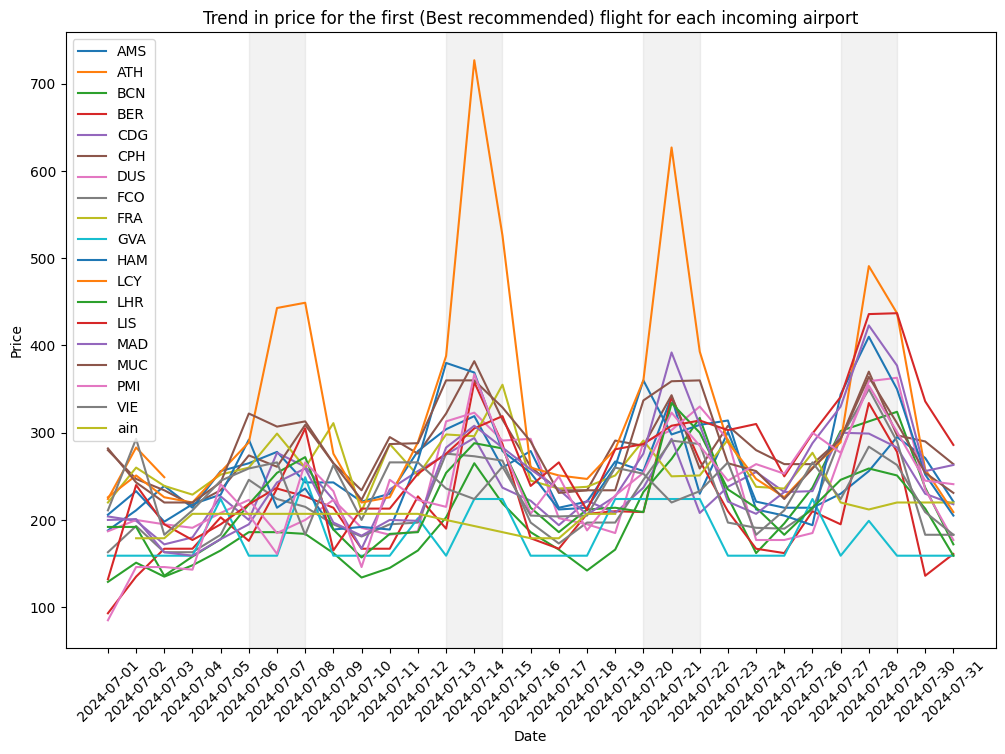

In [9]:
# Plot the trend in price for the first (Best recommended) flight for each incoming airport
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

for airport in price_stats.index:
    data = price_df[price_df['incoming'] == airport]
    # Go through each date and get the cheapest flight
    temp_data = []
    for date in data['departure_date'].unique():
        # Get the first flight for that date
        # print(data[data['departure_date'] == date]['price'].iloc[0])
        temp_data.append(data[data['departure_date'] == date]['price'].iloc[0])

        # temp_data.append(data[data['departure_date'] == date]['price'].min())

    ax.plot(data['departure_date'].unique(), temp_data, label=airport)

# Add background color for the weekends
dates = pd.date_range('2024-07-01', '2024-08-01', freq='D')

for i in range(len(dates)):
    if dates[i].weekday() == 6:
        ax.axvspan(i - 1, i + 1, color='grey', alpha=0.1)

ax.set_title('Trend in price for the first (Best recommended) flight for each incoming airport')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.xticks(rotation=45)
ax.legend()
plt.show()

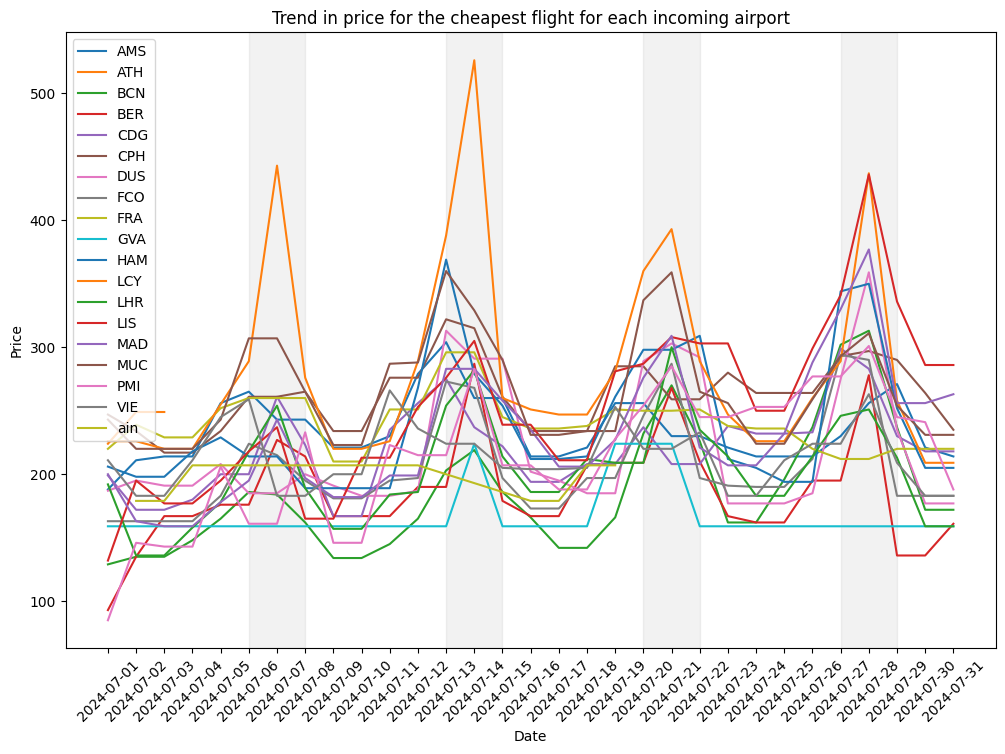

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for airport in price_stats.index:
    data = price_df[price_df['incoming'] == airport]
    # Go through each date and get the cheapest flight
    temp_data = []
    for date in data['departure_date'].unique():
        temp_data.append(data[data['departure_date'] == date]['price'].min())

    ax.plot(data['departure_date'].unique(), temp_data, label=airport)

# Add background color for the weekends
dates = pd.date_range('2024-07-01', '2024-08-01', freq='D')

for i in range(len(dates)):
    if dates[i].weekday() == 6:
        ax.axvspan(i - 1, i + 1, color='grey', alpha=0.1)

ax.set_title('Trend in price for the cheapest flight for each incoming airport')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.xticks(rotation=45)
ax.legend()
plt.show()

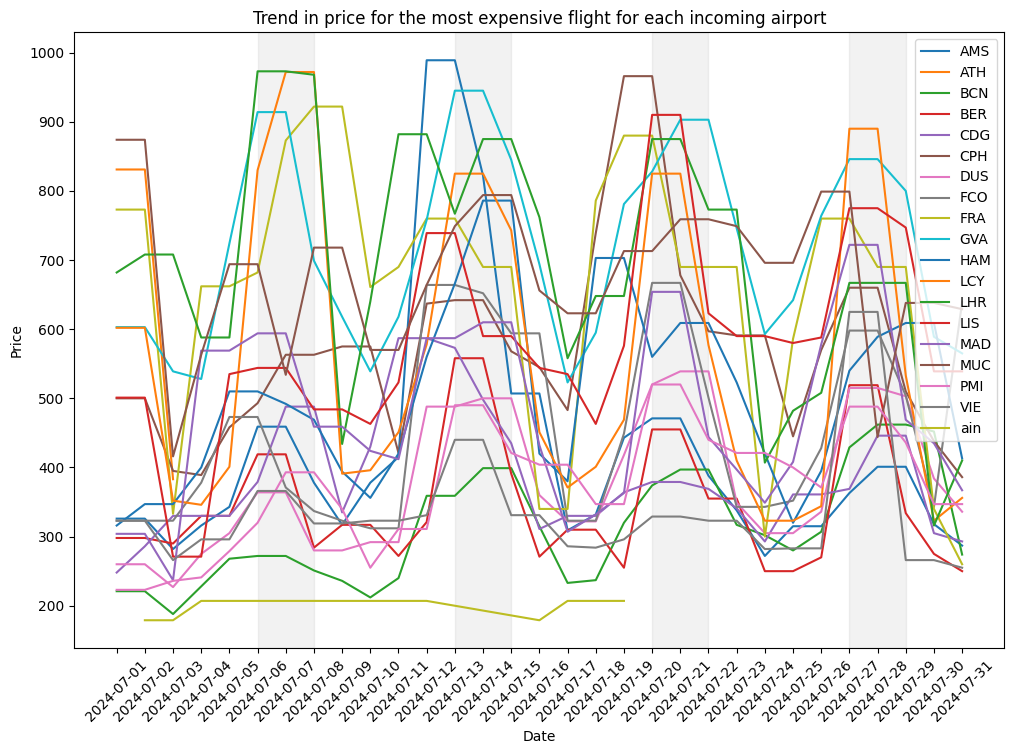

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for airport in price_stats.index:
    data = price_df[price_df['incoming'] == airport]
    # Go through each date and get the cheapest flight
    temp_data = []
    for date in data['departure_date'].unique():
        temp_data.append(data[data['departure_date'] == date]['price'].max())

    ax.plot(data['departure_date'].unique(), temp_data, label=airport)

# Add background color for the weekends
dates = pd.date_range('2024-07-01', '2024-08-01', freq='D')

for i in range(len(dates)):
    if dates[i].weekday() == 6:
        ax.axvspan(i - 1, i + 1, color='grey', alpha=0.1)

ax.set_title('Trend in price for the most expensive flight for each incoming airport')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.xticks(rotation=45)
ax.legend()
plt.show()

Above are the trends in flight prices for all the scraped routes. In the short and nearish term the only real trends you can see are weekend prices where there is a surge across almost every route.

Next ill go into more detail on the Zurich to Montreal route as I have a much longer timescale.

In [6]:
# Group by incoming and get the number of flights, unique airlines and average price
price_stats_yul = price_df_long.groupby('incoming').agg({'price': ['count', 'mean', 'min', 'max', 'median'], 'airline': 'nunique'})

price_stats_yul

price                               airline
         count        mean  min   max median nunique
incoming                                            
YUL       1990  587.364824  404  1125  556.0      79

In [27]:
# Convert the dates to datetime
price_df_long['departure_date'] = pd.to_datetime(price_df_long['departure_date'])
price_df_long['return_date'] = pd.to_datetime(price_df_long['return_date'])

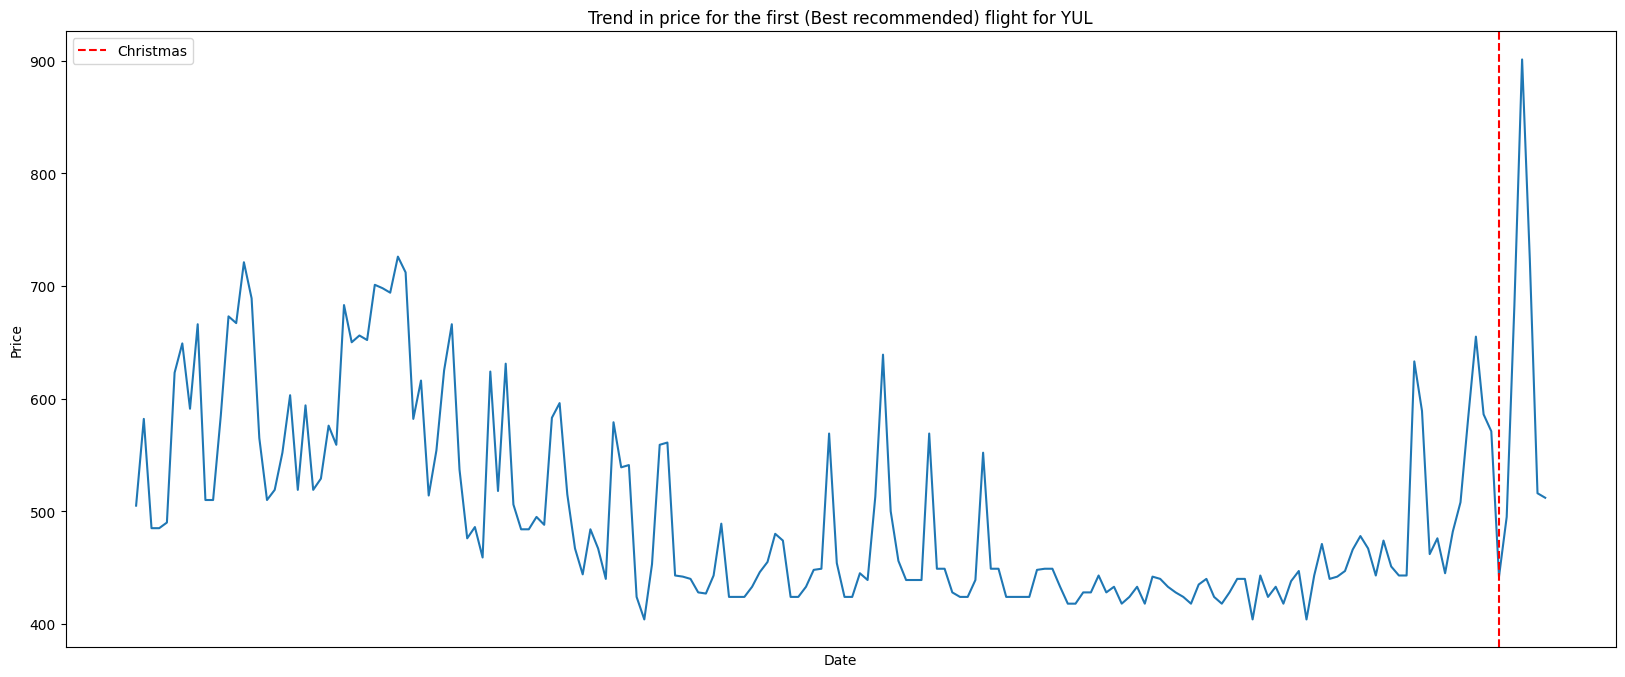

In [35]:
# Plot the trend in price for the first (Best recommended)
temp_data = []
for date in price_df_long['departure_date'].unique():
    temp_data.append(price_df_long[price_df_long['departure_date'] == date]['price'].iloc[0])

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_df_long['departure_date'].unique(), temp_data)

# Add annotation for christmas
ax.axvline(pd.to_datetime('2024-12-25'), color='red', linestyle='--', label='Christmas')

ax.set_title('Trend in price for the first (Best recommended) flight for YUL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.xticks([])
plt.show()

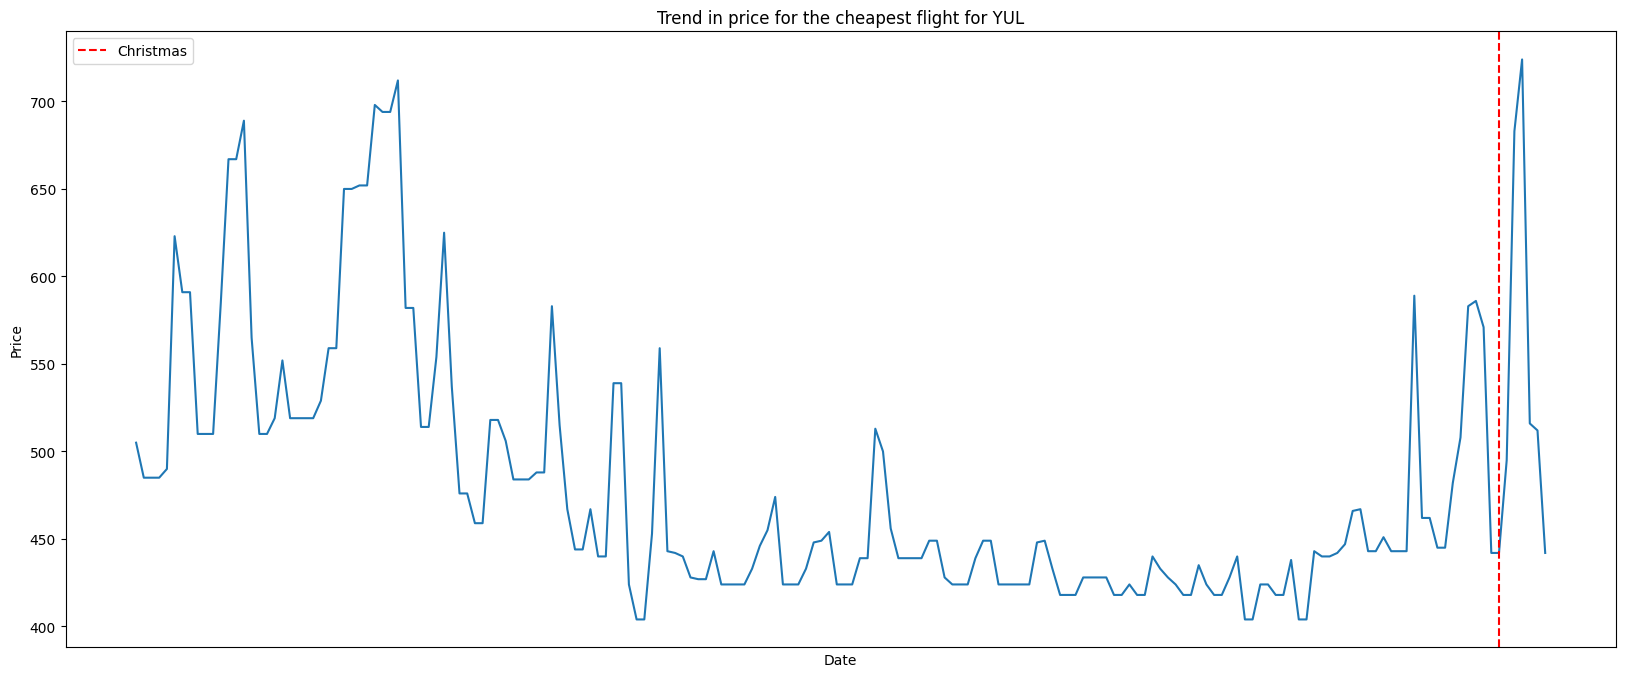

In [36]:
# Plot the trend in price for the first (Best recommended)
temp_data = []
for date in price_df_long['departure_date'].unique():
    temp_data.append(price_df_long[price_df_long['departure_date'] == date]['price'].min())

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_df_long['departure_date'].unique(), temp_data)

ax.axvline(pd.to_datetime('2024-12-25'), color='red', linestyle='--', label='Christmas')

ax.set_title('Trend in price for the cheapest flight for YUL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.xticks([])
plt.show()

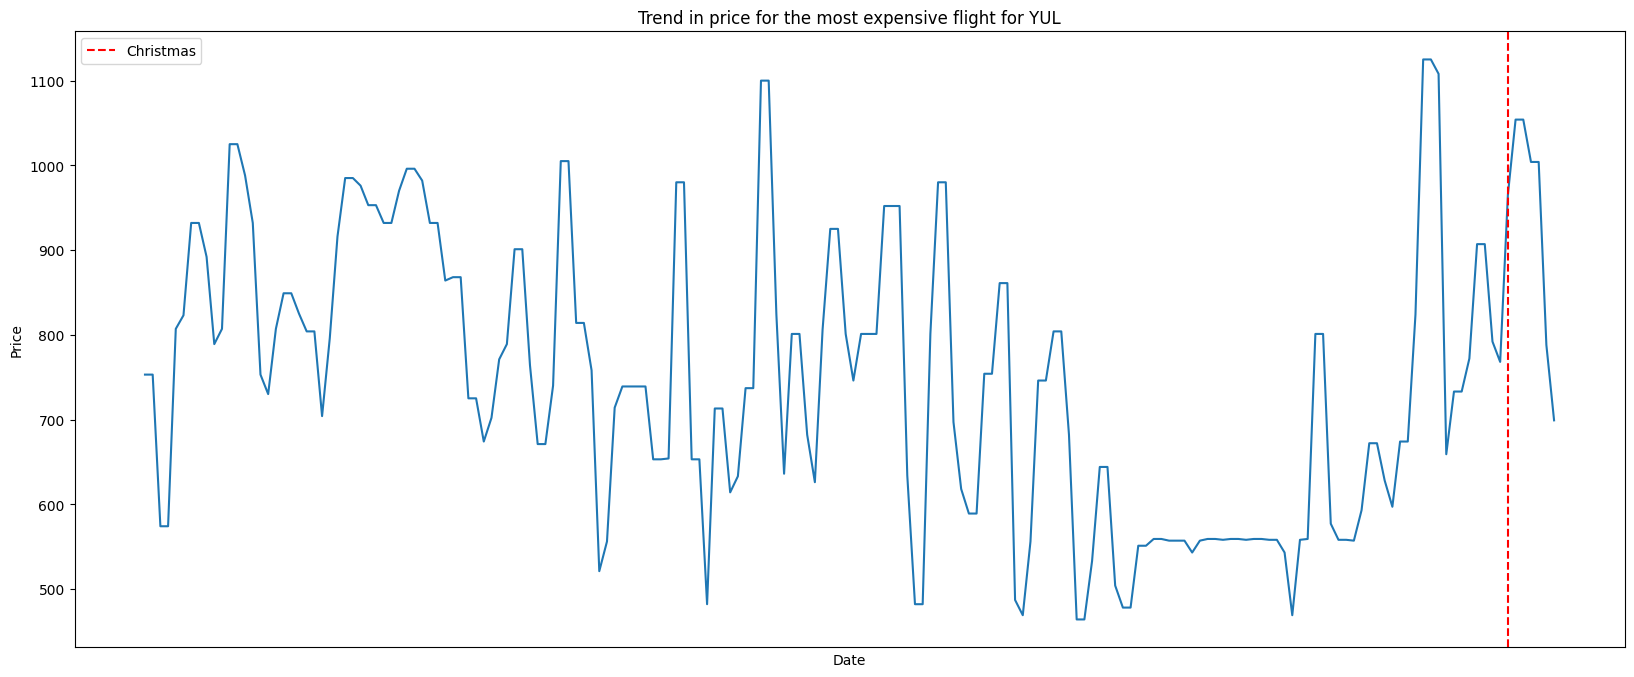

In [37]:
# Plot the trend in price for the first (Best recommended)

temp_data = []
for date in price_df_long['departure_date'].unique():
    temp_data.append(price_df_long[price_df_long['departure_date'] == date]['price'].max())

fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_df_long['departure_date'].unique(), temp_data)

ax.axvline(pd.to_datetime('2024-12-25'), color='red', linestyle='--', label='Christmas')

ax.set_title('Trend in price for the most expensive flight for YUL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.xticks([])
plt.show()

Taking a look at the 3 different "categories" there does seem to be an "ideal" time range to book flights. Although obviously the time before booking is not the only factor (seasonality, holidays and the rest) the plots seem to indicate that booking 3-4 months in advance is the sweet spot for this route. It would be interesting to see if this is a general trend for all routes, but the data scraping is a tad slow for 6 months of data.

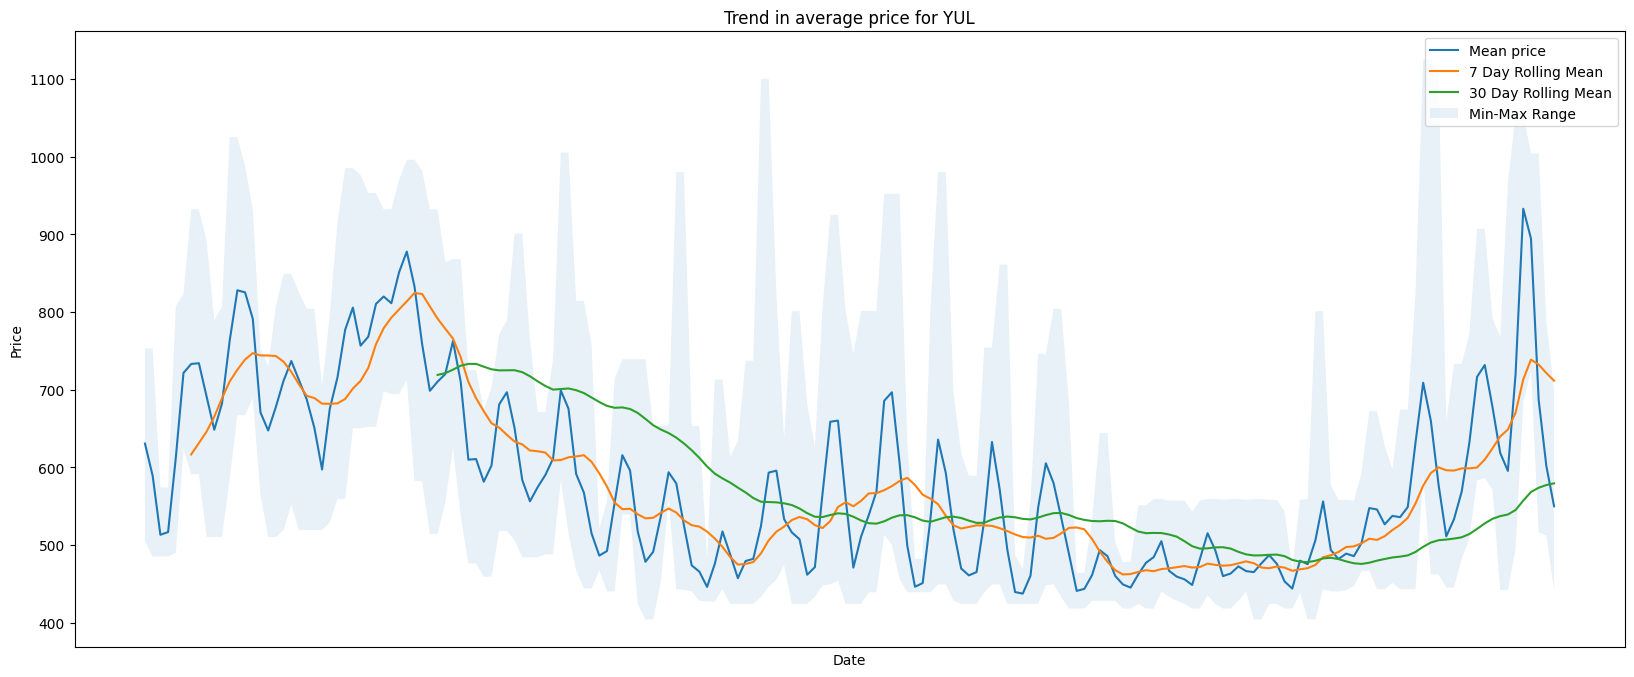

In [12]:
# Aggregate the data to get the average price for each date
price_df_long_agg = price_df_long.groupby('departure_date').agg({'price': ['mean', 'min', 'max', 'median']})

# Plot the trend in the average price with a 7 day rolling average and a band around the mean from min to max
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_df_long_agg.index, price_df_long_agg['price']['mean'], label='Mean price')
ax.plot(price_df_long_agg.index, price_df_long_agg['price']['mean'].rolling(window=7).mean(), label='7 Day Rolling Mean')
ax.plot(price_df_long_agg.index, price_df_long_agg['price']['mean'].rolling(window=39).mean(), label='30 Day Rolling Mean')
ax.fill_between(price_df_long_agg.index, price_df_long_agg['price']['min'], price_df_long_agg['price']['max'], alpha=0.1, label='Min-Max Range')

ax.set_title('Trend in average price for YUL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.xticks([])
plt.legend()
plt.show()

When combining the min max and "best" flights into one graph, very similar trends can be seen. Just like in the earlier shorter term data, seems to be an obvious weekend surge in prices across all categories. With the max prices being the most volatile. And again that 3-4 month sweet spot appears again with a pretty flat plateau of prices.

Overall though the floor and mean prices are pretty stable across the 6 months, with peaks showing during surge times like weekends and holidays. The most obvious one is the very rapid spike towards christmas time.